# (Probabilistic) Noise2Void (2D)

This notebook is a re-implementation of the code for denoising with [noise2void](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html) as proovided by the authors in this [repository](https://github.com/juglab/pn2v). Unlike the original code, this implementation uses pytorch instead of tensorflow. The key idea is to crop small tiles from image data, replace a given pixel with any other pixel in the tile and then try to predict the true intensity of the replaced pixel. Since the intensity of every pixel $i$ consists of two components noise $n$ and $s$ (intensity $i=n+s$), the network will inevitably fail to predict the noise component $n$ of the pixel - thus cleaning up the image in the process.

## Source code

Since the torch-implementation of noise2void is currently not (yet) pip-installlable, we simply clone the repository and import the functions provided therein.

In [32]:
!git clone https://github.com/juglab/pn2v.git

fatal: destination path 'pn2v' already exists and is not an empty directory.


In [33]:
import os
os.chdir('pn2v')

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import stackview

from unet.model import UNet
from pn2v import utils
from pn2v import training, prediction
import pn2v.histNoiseModel
from skimage import io
import stackview

device=utils.getDevice()

CUDA available? True


## Dataset

As a training dataset, we'll use [this data](https://zenodo.org/record/5837363) of a developing tribolium embryo.

In [35]:
root = '/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/denoising_example_data'
filename = os.path.join(root, 'convallaria.tif')
data = io.imread(filename)

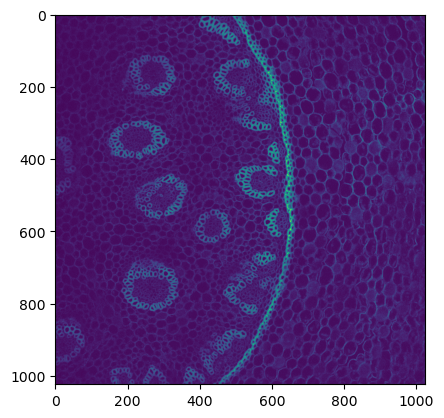

In [36]:
plt.imshow(data[40])

## Training

We next create the model:

In [37]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

Noise2void provides the `training.trainNetwork` function to run the training. The essential parameters here are the following:

- `numOfEpochs`: number of epochs to train
- `numOfIterations`: number of steps in each epochs
- `patchSize`: size of the patches to extract from the images
- `batchSize`: number of patches to use in each iteration

In [38]:
model_directory = './model'
os.makedirs(model_directory, exist_ok = True)

In [39]:
# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=data, valData=data,
                                           postfix='conv_N2V', directory=model_directory, noiseModel=None,
                                           device=device, numOfEpochs=20, stepsPerEpoch=10, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 0.5396011963486671+-(2SEM)0.1632045770490405      
Epoch 1 finished      
avg. loss: 0.14107346385717393+-(2SEM)0.03511942115563338      
Epoch 2 finished      
avg. loss: 0.1530279416590929+-(2SEM)0.03784216142151133      
Epoch 3 finished      
avg. loss: 0.14400796890258788+-(2SEM)0.0405738361070597      
Epoch 4 finished      
avg. loss: 0.12245606444776058+-(2SEM)0.03131022265661264      
Epoch 5 finished      
avg. loss: 0.09631720948964358+-(2SEM)0.02312176777554985      
Epoch 6 finished      
avg. loss: 0.10415804497897625+-(2SEM)0.01675637456608379      
Epoch 7 finished      
avg. loss: 0.12776857577264308+-(2SEM)0.03699295650252412      
Epoch 8 finished      
avg. loss: 0.10771282762289047+-(2SEM)0.03300412868589734      
Epoch 9 finished      
avg. loss: 0.11204689629375934+-(2SEM)0.02957868532185728      
Epoch 10 finished      
avg. loss: 0.0889200784265995+-(2SEM)0.01682425631985288      
Epoch 11 finished      
avg. loss: 0.0961350337

In [40]:
n2vResult = prediction.tiledPredict(data[40], net ,ps=256, overlap=48,
                                        device=device, noiseModel=None)

Text(0.5, 1.0, 'Noise2Void result')

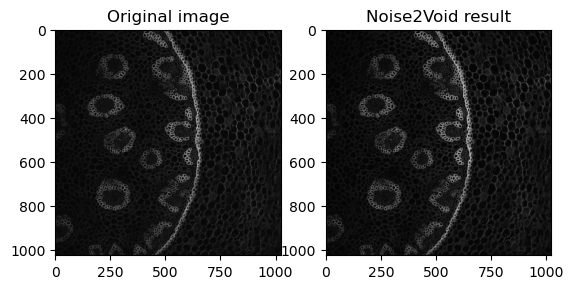

In [41]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(n2vResult, cmap='gray')
axes[1].set_title('Noise2Void result')

Text(0.5, 1.0, 'Noise2Void result')

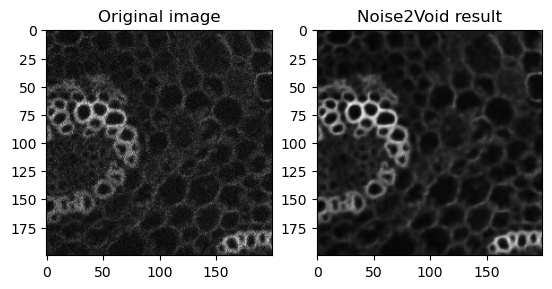

In [42]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40][800:1000, 0:200], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(n2vResult[800:1000, 0:200], cmap='gray')
axes[1].set_title('Noise2Void result')

In [43]:
stackview.curtain(data[40][800:1000, 0:200], n2vResult[800:1000, 0:200], zoom_factor=2)

## Process 3D data

Noise2Void generally runs under the assumption, that the noise between neighboring pixels is un-correlated. This assumption is valid in both 3D and 2D. While the performance is probably worse than using a real 3D convolutional network, it is still legitimate too apply noise2void slice by slice to the data stack:

In [44]:
denoised_image = np.zeros_like(data)

for z in range(data.shape[0]):
    denoised_image[z] = prediction.tiledPredict(data[z], net ,ps=256, overlap=48,
                                        device=device, noiseModel=None)

Text(0.5, 1.0, 'Noise2Void result')

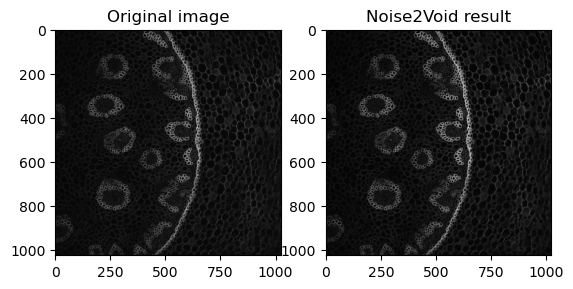

In [47]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40, :, :], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(denoised_image[40, :, :], cmap='gray')
axes[1].set_title('Noise2Void result')

Text(0.5, 1.0, 'Noise2Void result')

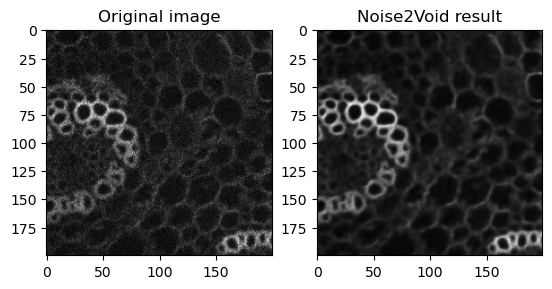

In [48]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[40, 800:1000, 0:200], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(denoised_image[40, 800:1000, 0:200], cmap='gray')
axes[1].set_title('Noise2Void result')

In [49]:
stackview.curtain(data[40], denoised_image[40], zoom_factor=0.5)